In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00709.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00372.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01850.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02017.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02363.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01

In [2]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [4]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")
IMG_PATH2 = glob.glob("/kaggle/input/anti-uav-yolo-1024/valid/images/*.jpg")

In [5]:
def convert_format(box, iwidth=256, iheight=256):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [6]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((256, 256))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")


Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


In [7]:
valid_image = []
valid_image_path = []
valid_image_id = []
valid_annotation = []

for img_path in IMG_PATH2:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/valid/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((258, 258))
            valid_image.append(np.asarray(nmpy_img))
            valid_image_path.append(img_path)
            valid_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                valid_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")


Images and annotations processed successfully.


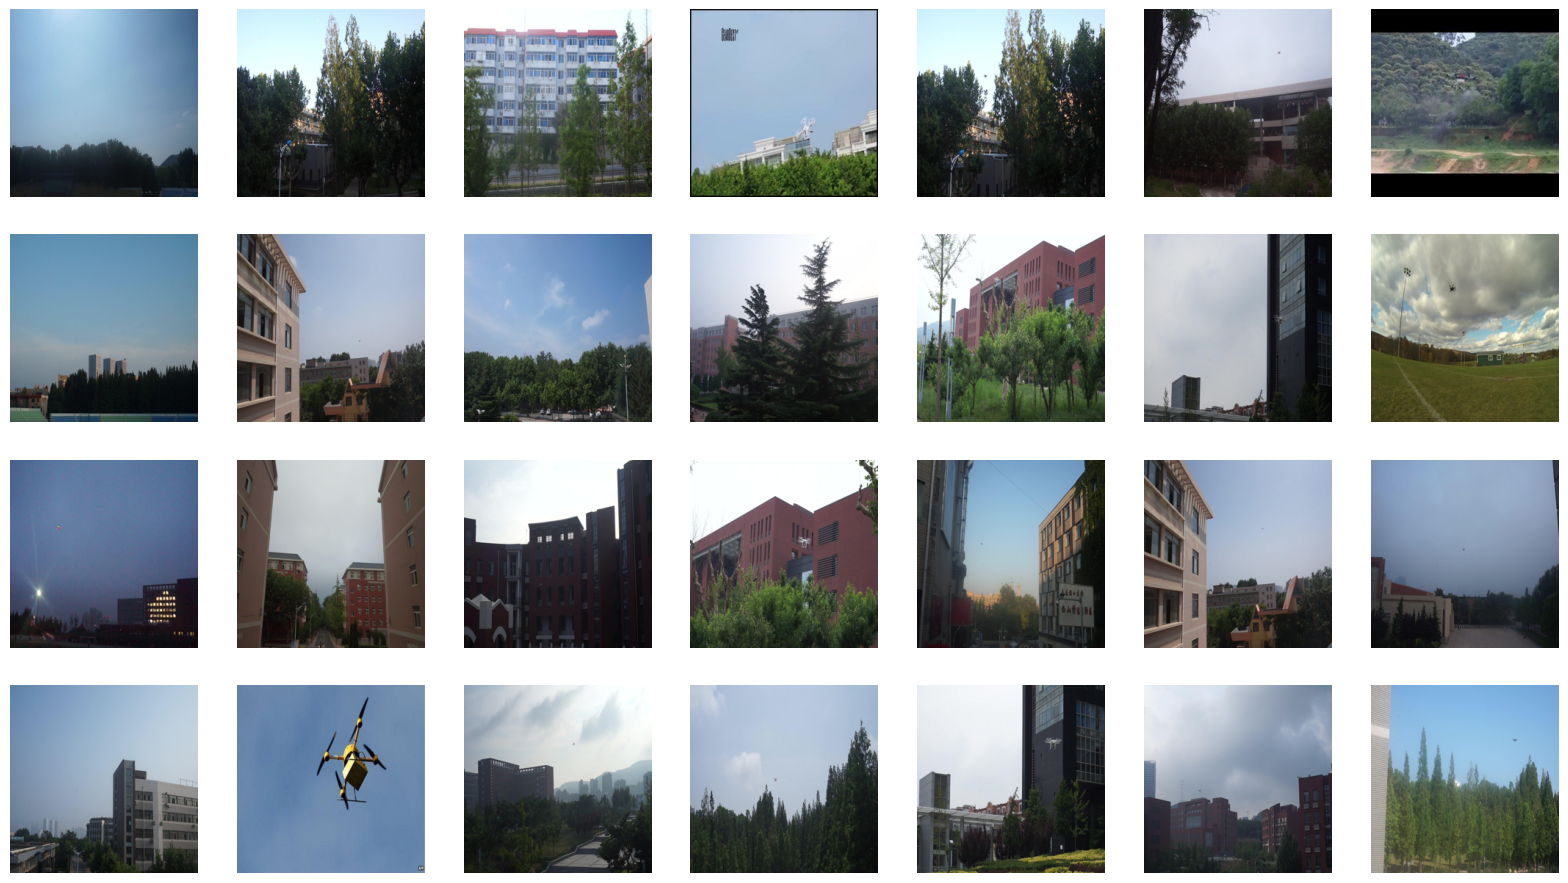

In [8]:
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [9]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

df2 = pd.DataFrame()
df2['boxes'] = valid_annotation
df2['img_path'] = valid_image_path
df2['labels'] = 'drone'
df2['img_id'] = valid_image_id

In [10]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

df2['labels'] = enc.fit_transform(df2['labels'])
df2['labels'] = np.stack([df2['labels'][i]+1 for i in range(len(df2['labels']))])

In [11]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

df2[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df2['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df2.drop(columns=['boxes'], inplace=True)
df2['xmin'] = df2['xmin'].astype(float)
df2['ymin'] = df2['ymin'].astype(float)
df2['xmax'] = df2['xmax'].astype(float)
df2['ymax'] = df2['ymax'].astype(float)

In [43]:
df_removed_damaged1 = df.drop(df[(df.ymin > df.ymax) | (df.xmin > df.xmax)].index)
df_removed_damaged1

mask = (df['ymin'] >= 256) | (df['ymax'] >= 256) | (df['xmin'] >= 256) | (df['xmax'] >= 256)
# Drop rows where the condition is True
df_removed_damaged = df_removed_damaged1.drop(df[mask].index)

df2_removed_damaged1 = df2.drop(df2[(df2.ymin >= df2.ymax) | (df2.xmin >= df2.xmax)].index)
df2_removed_damaged1

mask1 = (df2['ymin'] >= 256) | (df2['ymax'] >= 256) | (df2['xmin'] >= 256) | (df2['xmax'] >= 256)
# Drop rows where the condition is True
df2_removed_damaged = df2_removed_damaged1.drop(df2[mask1].index)

In [44]:
train_ds=df_removed_damaged
val_ds=df2_removed_damaged
val_ds

img_path  labels img_id   xmin  \
0     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  02371   30.0   
1     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00767  164.0   
2     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  02360  200.0   
3     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00266   88.0   
4     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  02450  182.0   
...                                                 ...     ...    ...    ...   
2595  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00319  114.0   
2596  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01863  108.0   
2597  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01325  130.0   
2598  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00222   66.0   
2599  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00117  152.0   

       ymin   xmax   ymax  
0     166.0   38.0  171.0  
1     139.0  169.0  142.0  
2     132.0  207.0  137.0  
3     142.0  179.0  179.0  
4      95.0  187.0  100.0  
...     ...    ...    ...  
2595   65.0  134.0   77.0  
2596   31.0  112.0   36.0  
2597  145.0  134.0  149.0  
2598   93.0   86.0  108.0  
2599  107.0  163.0  122.0  

[2592 rows x 7 columns]

In [45]:
selected_values = df_removed_damaged[df_removed_damaged['ymax'] > 256]['ymax']

# Print the selected values
print(selected_values)

Series([], Name: ymax, dtype: float64)


In [46]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (256, 256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        if len(boxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([index]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros(0, dtype=torch.int64)
            }
        else:

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            label = records['labels'].values
            labels = torch.as_tensor(label, dtype=torch.int64)

            # Suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([index]),
                'area': area,
                'iscrowd': iscrowd
            }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # Only stack the boxes if there are non-empty bounding boxes
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]


In [47]:
def get_transform_train():
    return A.Compose([
        #A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [48]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TrainDataset(train_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())
valid_dataset = TrainDataset(val_ds, '/kaggle/input/anti-uav-yolo-1024/valid/images', get_transform_train())

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [50]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
#targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]

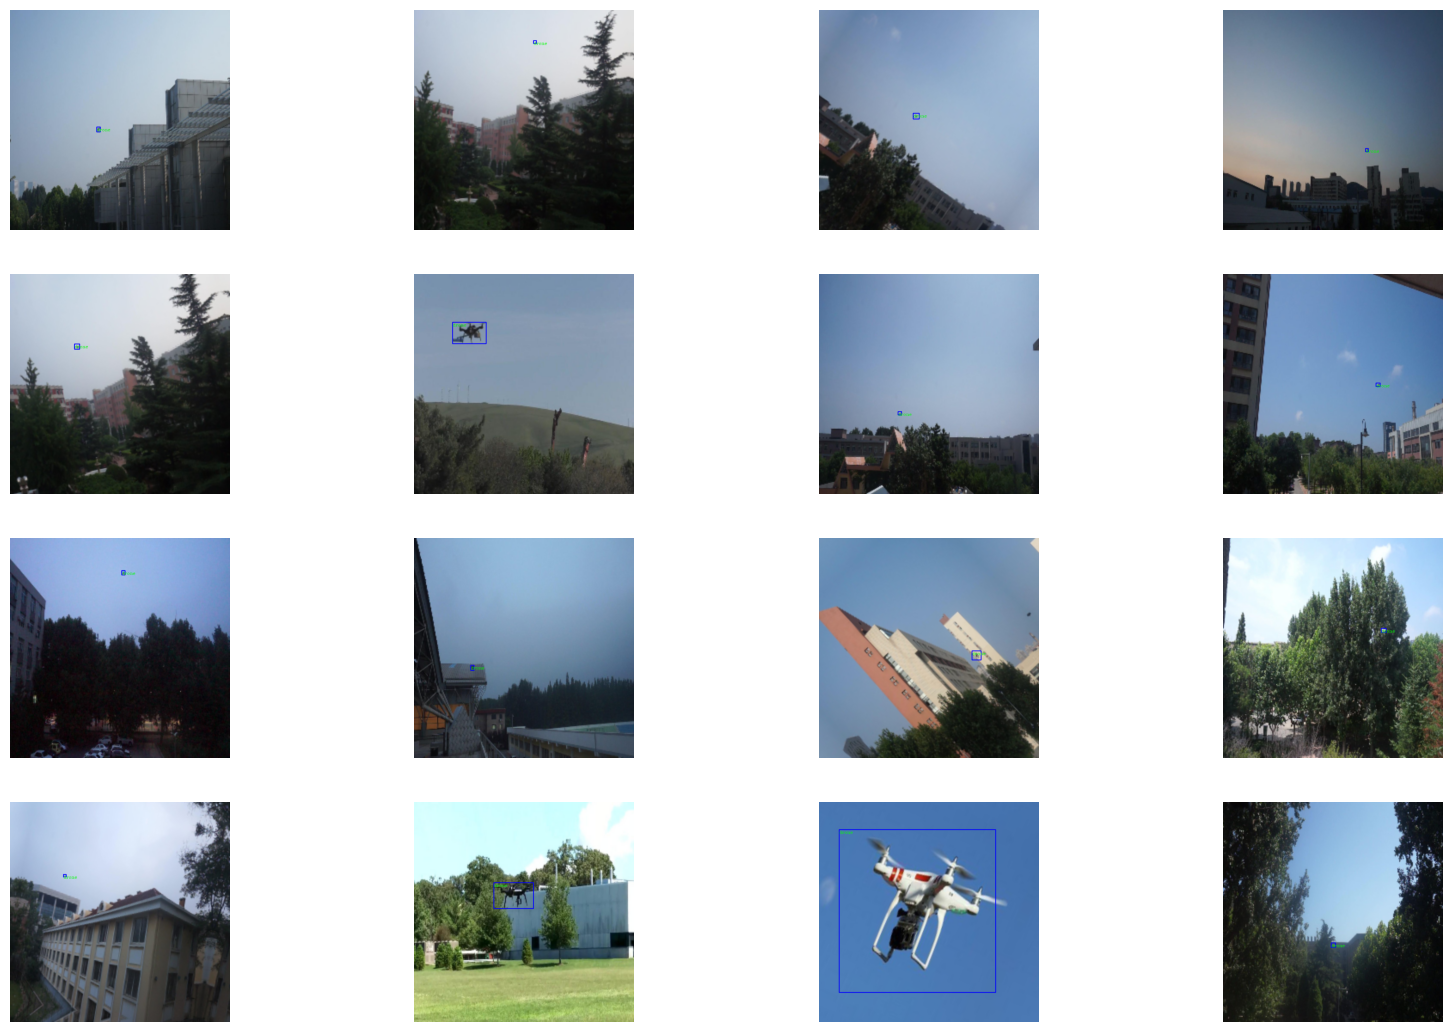

In [51]:
classes= {1:'drone'}

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(6,4, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy() * 255
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [52]:
for i, (image, target) in enumerate(zip(images, targets)):
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    for i,box in enumerate(boxes):
        print(box[0], box[1],box[2], box[3])
        

315 425 328 443
434 111 445 121
342 375 364 396
518 503 528 515
234 254 253 273
140 175 262 253
287 500 300 512
556 396 571 409
406 118 418 134
206 462 218 481
556 410 589 443
575 328 593 343
194 263 204 272
290 293 434 387
73 100 642 692
393 512 409 528


In [53]:
4fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (drone) + background
# get number of input features for the classifier
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [55]:
fasterrcnn.to(device)
optimizer = torch.optim.SGD(fasterrcnn.parameters(), lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)

In [56]:
from tqdm import tqdm
def train_epoch(model, train_data, optim, n_epoch):
    model.train()
    batches_loss = 0
    writer = list()
    len_train_sample = len(train_data)
    epoch_loss = 0
    print(f"Epoch #{n_epoch} started!\n")
    print(f"----------------------------Train started!----------------------------")
    for batch in tqdm(train_data):
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optim.zero_grad()
        losses = model(imgs, targets)
        loss = sum(loss for loss in losses.values())
        writer.append(loss/len(batch))
        batches_loss += writer[-1]
        loss.backward()
        optim.step()
        #print(f"Mean batch loss: {writer[-1]}")
    epoch_loss = batches_loss/len_train_sample
    print(f"Mean epoch loss: {epoch_loss}\n----------------------------\n")
    return epoch_loss, writer

In [57]:
@torch.no_grad()
def validate_epoch(model, val_data, optim):
    model.train()
    writer = list()
    len_val_sample = len(val_data)
    batches_loss = 0
    print(f"----------------------------Validate started!----------------------------")
    for batch in val_data:
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optim.zero_grad()
        losses = model(imgs, targets)
        loss = sum(loss for loss in losses.values())
        writer.append(loss/len(batch))
        batches_loss += writer[-1]
        #print(f"Mean batch loss: {writer[-1]}")
    epoch_loss = batches_loss/len_val_sample
    print(f"Mean epoch loss: {epoch_loss}\n----------------------------\n")
    return epoch_loss, writer

In [58]:
epochs = 20
train_loss = list()
val_loss = list()
iter_train_loss = list()
iter_val_loss = list()

for epoch in range(epochs):
    tr_loss, it_tr_loss = train_epoch(fasterrcnn, train_data_loader, optimizer, epoch)
    train_loss.append(tr_loss.to("cpu"))
    iter_train_loss.extend([i.to("cpu").item() for i in it_tr_loss])
    vl_loss, it_vl_loss = validate_epoch(fasterrcnn, valid_data_loader, optimizer)
    val_loss.append(vl_loss.to("cpu"))
    iter_val_loss.extend([i.to("cpu").item() for i in it_vl_loss])

Epoch #0 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.15166365275742522
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.14061077664736504
----------------------------

Epoch #1 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.13267744617911173
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.12842938441375254
----------------------------

Epoch #2 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.12785201307272712
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.12654242080480757
----------------------------

Epoch #3 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.12207059950176792
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.11976285520515816
----------------------------

Epoch #4 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.11551775097785867
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.11616887169192941
----------------------------

Epoch #5 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.10979916219967618
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.11302459484717144
----------------------------

Epoch #6 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.10618752548628806
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.1071601976197516
----------------------------

Epoch #7 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.10168140262204595
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.10734744201972708
----------------------------

Epoch #8 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.100725019025425
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.10206773747886515
----------------------------

Epoch #9 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.09728481180557613
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.09778323134634044
----------------------------

Epoch #10 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.0938050767920537
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.09611154754342177
----------------------------

Epoch #11 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.09125319090724188
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.09436358030755754
----------------------------

Epoch #12 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.09143569793407945
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.0952283583564396
----------------------------

Epoch #13 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.08847668971460568
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.09664837252970132
----------------------------

Epoch #14 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.08749275411925417
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.09363594853380462
----------------------------

Epoch #15 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.08579722569563455
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.09408965428215103
----------------------------

Epoch #16 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.08396469464530514
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.0916191440826074
----------------------------

Epoch #17 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.08291573857191793
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.08804411865949444
----------------------------

Epoch #18 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.08173938016493391
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.09166629003687267
----------------------------

Epoch #19 started!

----------------------------Train started!----------------------------


100%|██████████| 324/324 [07:55<00:00,  1.47s/it]


Mean epoch loss: 0.08032292739241167
----------------------------

----------------------------Validate started!----------------------------
Mean epoch loss: 0.08904967974303792
----------------------------



In [59]:
train_loss

[tensor(0.1517, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1327, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1279, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1221, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1155, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1098, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1062, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1017, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.1007, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0973, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0938, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0913, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0914, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0885, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0875, dtype=torch.float64, grad_fn=<ToCopyBackward0>),
 tensor(0.0858, dtype=tor

In [60]:
val_loss

[tensor(0.1406, dtype=torch.float64),
 tensor(0.1284, dtype=torch.float64),
 tensor(0.1265, dtype=torch.float64),
 tensor(0.1198, dtype=torch.float64),
 tensor(0.1162, dtype=torch.float64),
 tensor(0.1130, dtype=torch.float64),
 tensor(0.1072, dtype=torch.float64),
 tensor(0.1073, dtype=torch.float64),
 tensor(0.1021, dtype=torch.float64),
 tensor(0.0978, dtype=torch.float64),
 tensor(0.0961, dtype=torch.float64),
 tensor(0.0944, dtype=torch.float64),
 tensor(0.0952, dtype=torch.float64),
 tensor(0.0966, dtype=torch.float64),
 tensor(0.0936, dtype=torch.float64),
 tensor(0.0941, dtype=torch.float64),
 tensor(0.0916, dtype=torch.float64),
 tensor(0.0880, dtype=torch.float64),
 tensor(0.0917, dtype=torch.float64),
 tensor(0.0890, dtype=torch.float64)]

In [61]:
trainloss = [tensor.item() for tensor in train_loss]
valloss= [tensor.item() for tensor in val_loss]

In [62]:
print(trainloss)

[0.15166365275742522, 0.13267744617911173, 0.12785201307272712, 0.12207059950176792, 0.11551775097785867, 0.10979916219967618, 0.10618752548628806, 0.10168140262204595, 0.100725019025425, 0.09728481180557613, 0.0938050767920537, 0.09125319090724188, 0.09143569793407945, 0.08847668971460568, 0.08749275411925417, 0.08579722569563455, 0.08396469464530514, 0.08291573857191793, 0.08173938016493391, 0.08032292739241167]


In [63]:
print(valloss)

[0.14061077664736504, 0.12842938441375254, 0.12654242080480757, 0.11976285520515816, 0.11616887169192941, 0.11302459484717144, 0.1071601976197516, 0.10734744201972708, 0.10206773747886515, 0.09778323134634044, 0.09611154754342177, 0.09436358030755754, 0.0952283583564396, 0.09664837252970132, 0.09363594853380462, 0.09408965428215103, 0.0916191440826074, 0.08804411865949444, 0.09166629003687267, 0.08904967974303792]


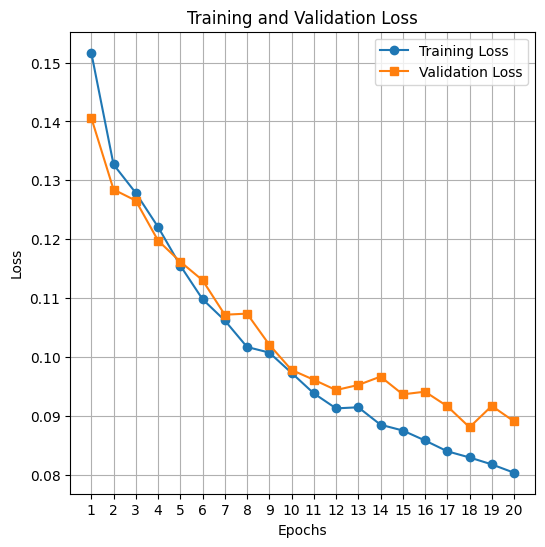

In [64]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(6, 6))
plt.plot(range(1, epochs+1), trainloss, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), valloss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

In [65]:
torch.save(fasterrcnn, 'fasterrcnnogmodel.pth')

In [66]:
torch.save(fasterrcnn.state_dict(), 'fasterrcnnogmodel_state_dict.pth')

In [67]:
with open('loss_values.txt', 'w') as file:
    file.write('Train Loss\n')
    for item in trainloss:
        file.write(f'{item}\n')
    file.write('\n')
    file.write('Validation Loss\n')
    for item in valloss:
        file.write(f'{item}\n')

In [76]:
torch.save(fasterrcnn.state_dict(), 'model_weights.pth')

In [69]:
!pip install pycocotools
! pip install -U ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=32e02c2ddeddfdd9fab1fc5295ce219bdfa83fab3e5260883f9ab87740d8f522
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [72]:
from torchmetrics.detection import MeanAveragePrecision
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)
MeanAveragePrecision()

ModuleNotFoundError: `MAP` metric requires that `pycocotools` or `faster-coco-eval` installed. Please install with `pip install pycocotools` or `pip install faster-coco-eval` or `pip install torchmetrics[detection]`.

In [73]:
threshold=0.25
iou_threshold=0.75
iou=10
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [74]:
fasterrcnn.eval()
with torch.no_grad():
    for imgs,targets in valid_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
        
results=metric.compute()

NameError: name 'modelf' is not defined

In [ ]:
fast_mean_ap=results["map"].item()
fast_mean_ap_50=results["map_50"].item()
fast_mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {fast_mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {fast_mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {fast_mean_ap_75:.4f}")